In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.tracking.client import MlflowClient
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

from utils import get_results_dict, get_metrics_history_df

In [23]:
mlflow_tracking_uri = "file:///home/akira/Desktop/p-poteka/poteka-pipeline-pytorch/mlruns"
mlflow_experiment_id = "10"
save_img_dir_path = f"./results/{mlflow_experiment_id}/r2_score/standard"

os.makedirs(save_img_dir_path, exist_ok=True)

In [24]:
mlflow.set_tracking_uri(mlflow_tracking_uri)
standard_eval_runs = MlflowClient().search_runs("10", filter_string="tags.mlflow.project.entryPoint = 'evaluate'")
print(f"standard evaluate runs count: {len(standard_eval_runs)}")

standard evaluate runs count: 14


In [25]:
import re
from typing import Optional, List, Dict
# Get each cases r2 score

def get_timeseries_metrics(runs: List[mlflow.entities.run.Run]) -> Dict[str, pd.DataFrame]:
    # timeseries_r2_score_dict = {idx: pd.DataFrame(columns=["Pred_Value", "hour-rain"]) for idx in range(6)}
    timeseries_metrics_df = pd.DataFrame(columns=["time_idx", "case_name", "r2score", "rmse", "input_parameters"])
    all_data_metrics_df = pd.DataFrame(columns=["Pred_Value", "hour-rain", "case_name", "input_parameters", "time_idx"])
    for run in runs:
        input_parameters = run.data.tags["mlflow.runName"].replace("_evaluation", "")
        artifact_path = run.info.artifact_uri.replace("file://", "")
        eval_root_dir_path = os.path.join(artifact_path, "evaluations")
        case_result_dir_names = [f for f in os.listdir(os.path.join(eval_root_dir_path)) if re.match("^(?!Sequential).*_start$", f) is not None]
        pred_observ_filenames_dict = {case_name: get_pred_observ_filenames(os.path.join(eval_root_dir_path, case_name)) for case_name in case_result_dir_names}
        for case_name in case_result_dir_names:
            pred_observ_filenames_list = pred_observ_filenames_dict[case_name]
            for idx, fname in enumerate(pred_observ_filenames_list):
                idx = 10 if idx == 0 else 10 * (idx + 1)
                pred_result_df = pd.read_csv(os.path.join(eval_root_dir_path, case_name, fname))
                pred_result_df["input_parameters"] = input_parameters
                pred_result_df["time_idx"] = idx
                pred_result_df["case_name"] = case_name
                all_data_metrics_df = pd.concat([all_data_metrics_df, pred_result_df[["Pred_Value", "hour-rain", "case_name", "input_parameters", "time_idx"]]], axis=0, ignore_index=True)
                r2_score_val = get_r2_score_from_df(pred_result_df=pred_result_df)
                rmse_val = get_rmse_from_df(pred_result_df=pred_result_df)
                timeseries_metrics_df.loc[len(timeseries_metrics_df.index)] = [idx, case_name, r2_score_val, rmse_val, input_parameters]
    return {"timeseries_metrics": timeseries_metrics_df, "all_data_metrics": all_data_metrics_df}

def get_pred_observ_filenames(root_dir_path: str) -> list:
    # sorted filenames like [pred_observ_df_6-0.csv, pred_observ_df_6-10.csv, pred_observ_df_6-20.csv,...
    result_csv_name_regex = "^pred_observ_df_.*.csv$"
    return sorted([fname for fname in os.listdir(root_dir_path) if re.match(result_csv_name_regex, fname) is not None])

def get_r2_score_from_df(csv_df_file_path: Optional[str] = None, pred_result_df: Optional[pd.DataFrame] = None) -> float:
    if isinstance(csv_df_file_path, str):
        pred_result_df = pd.read_csv(csv_df_file_path)
        return float(r2_score(pred_result_df["hour-rain"].astype(float).values, pred_result_df["Pred_Value"].astype(float).values))
    elif isinstance(pred_result_df, pd.DataFrame):
        return float(r2_score(pred_result_df["hour-rain"].astype(float).values, pred_result_df["Pred_Value"].astype(float).values))
    else:
        raise ValueError("You must set only one of csv_df_file_path or pred_result_df")


def get_rmse_from_df(csv_df_file_path: Optional[str] = None, pred_result_df: Optional[pd.DataFrame] = None) -> float:
    if isinstance(csv_df_file_path, str):
        pred_result_df = pd.read_csv(csv_df_file_path)
        return mean_squared_error(
            np.ravel(pred_result_df["hour-rain"].values),
            np.ravel(pred_result_df["Pred_Value"].values),
            squared=False,
        )
    elif isinstance(pred_result_df, pd.DataFrame):
        return mean_squared_error(
            np.ravel(pred_result_df["hour-rain"].values),
            np.ravel(pred_result_df["Pred_Value"].values),
            squared=False,
        )
    else:
        raise ValueError("You must set only one of csv_df_file_path or pred_result_df.")


In [26]:
metrics_result = get_timeseries_metrics(standard_eval_runs)
timeseries_metrics_df = metrics_result["timeseries_metrics"]
all_data_metrics_df = metrics_result["all_data_metrics"]

In [27]:
timeseries_metrics_df.head()

,time_idx,case_name,r2score,rmse,input_parameters
0,10,NOT_TC_case_2019-10-04_5-20_start,0.970857,2.060881,RainWind
1,20,NOT_TC_case_2019-10-04_5-20_start,0.949312,2.104024,RainWind
2,30,NOT_TC_case_2019-10-04_5-20_start,0.383910,5.057501,RainWind
3,40,NOT_TC_case_2019-10-04_5-20_start,-3.086778,8.211860,RainWind
4,50,NOT_TC_case_2019-10-04_5-20_start,-6.099221,10.030273,RainWind


In [28]:
timeseries_metrics_df.describe()

,time_idx,r2score,rmse
count,6048.000000,6048.000000,6048.000000
mean,35.000000,-37.282436,5.883972
std,17.079663,344.696031,5.969899
min,10.000000,-7882.358869,0.236435
25%,20.000000,-1.381134,0.893747
50%,35.000000,0.000000,3.683720
75%,50.000000,0.575413,9.511520
max,60.000000,0.991975,30.467956


In [29]:
all_data_metrics_df.head()

,Pred_Value,hour-rain,case_name,input_parameters,time_idx
0,0.364,0.0,NOT_TC_case_2019-10-04_5-20_start,RainWind,10
1,1.812,0.5,NOT_TC_case_2019-10-04_5-20_start,RainWind,10
2,0.406,0.0,NOT_TC_case_2019-10-04_5-20_start,RainWind,10
3,7.147,5.5,NOT_TC_case_2019-10-04_5-20_start,RainWind,10
4,9.47,8.0,NOT_TC_case_2019-10-04_5-20_start,RainWind,10


In [30]:
all_data_metrics_df.describe()

,Pred_Value,hour-rain,case_name,input_parameters,time_idx
count,184464.000,184464.0,184464,184464,184464
unique,25600.000,133.0,72,14,6
top,0.429,0.0,NOT_TC_case_2020-07-04_8-40_start,RainWind,10
freq,380.000,101682.0,2772,13176,30744


Text(0, 0.5, 'RMSE (mm/h)')

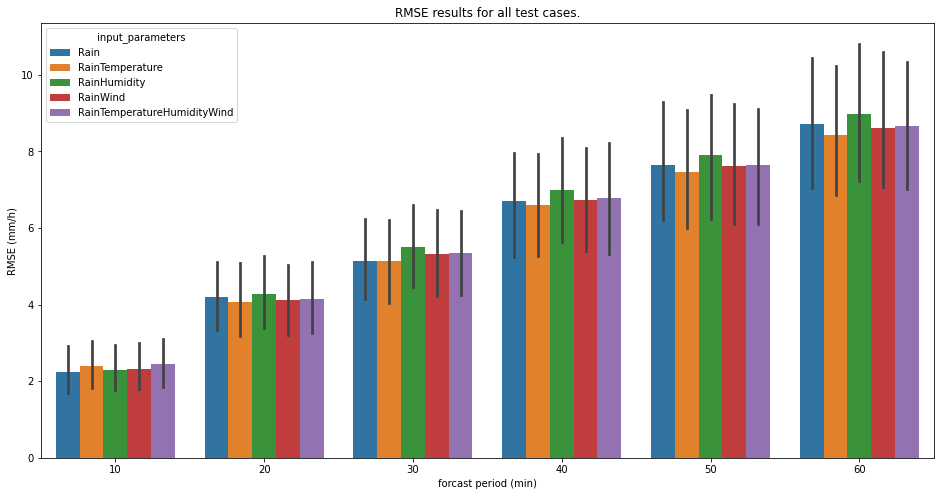

In [31]:
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=timeseries_metrics_df.loc[timeseries_metrics_df["input_parameters"].isin(target_cols)], x="time_idx", y="rmse", hue="input_parameters", ci=95, hue_order=target_cols)
ax.set_xlabel("forcast period (min)")
ax.set_title("RMSE results for all test cases.")
ax.set_ylabel("RMSE (mm/h)")

Text(0, 0.5, 'RMSE (mm/h)')

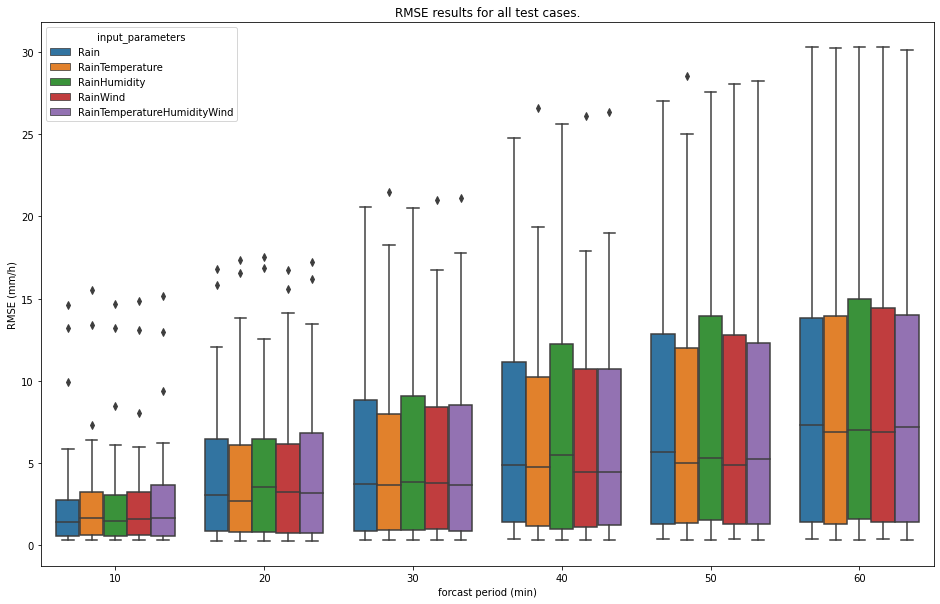

In [32]:
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
plt.figure(figsize=(16, 10))
ax = sns.boxplot(data=timeseries_metrics_df.loc[timeseries_metrics_df["input_parameters"].isin(target_cols)], x="time_idx", y="rmse", hue="input_parameters", hue_order=target_cols)
ax.set_xlabel("forcast period (min)")
ax.set_title("RMSE results for all test cases.")
ax.set_ylabel("RMSE (mm/h)")

Text(0.5, 0, 'forcast period (min)')

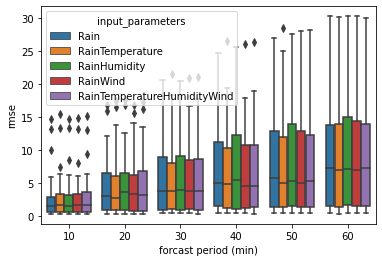

In [33]:
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
ax = sns.boxplot(data=timeseries_metrics_df.loc[timeseries_metrics_df["input_parameters"].isin(target_cols)], x="time_idx", y="rmse", hue="input_parameters", hue_order=target_cols)
ax.set_xlabel("forcast period (min)")

Text(0.5, 0, 'forcast period (min)')

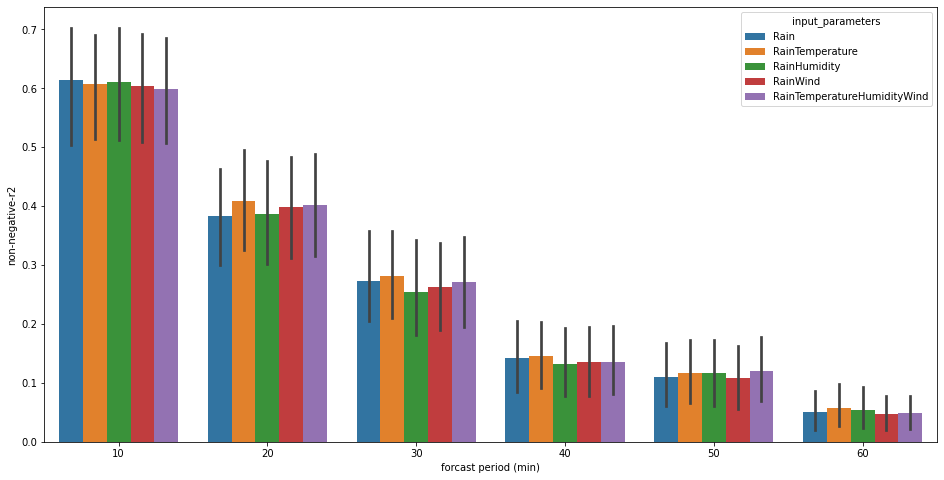

In [34]:
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
timeseries_metrics_df["non-negative-r2"] = np.where(timeseries_metrics_df["r2score"] < 0, 0, timeseries_metrics_df["r2score"])
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=timeseries_metrics_df.loc[timeseries_metrics_df["input_parameters"].isin(target_cols)], x="time_idx", y="non-negative-r2", hue="input_parameters", ci=95, hue_order=target_cols)
ax.set_xlabel("forcast period (min)")

In [35]:
# all data metrics
all_data_rmse_df = pd.DataFrame(columns=["input_parameters", "time_idx", "rmse", "r2score"])
for group_name, df in all_data_metrics_df.groupby(by=["input_parameters", "time_idx"]):
    rmse_val = get_rmse_from_df(pred_result_df=df)
    r2score_val = get_r2_score_from_df(pred_result_df=df)
    all_data_rmse_df.loc[len(all_data_rmse_df)] = [group_name[0], group_name[1], rmse_val, r2score_val]

all_data_rmse_df.head()

,input_parameters,time_idx,rmse,r2score
0,Rain,10,3.370621,0.899290
1,Rain,20,5.612555,0.714529
2,Rain,30,6.860969,0.577973
3,Rain,40,8.806181,0.289190
4,Rain,50,10.198274,0.051794


Text(0.5, 0, 'forcast period (min)')

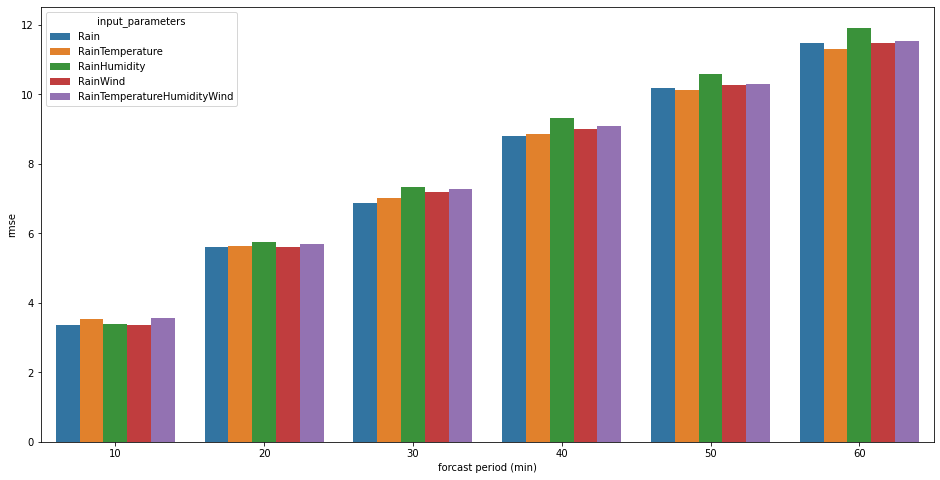

In [36]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=all_data_rmse_df, x="time_idx", y="rmse", hue="input_parameters", hue_order=target_cols)
ax.set_xlabel("forcast period (min)")

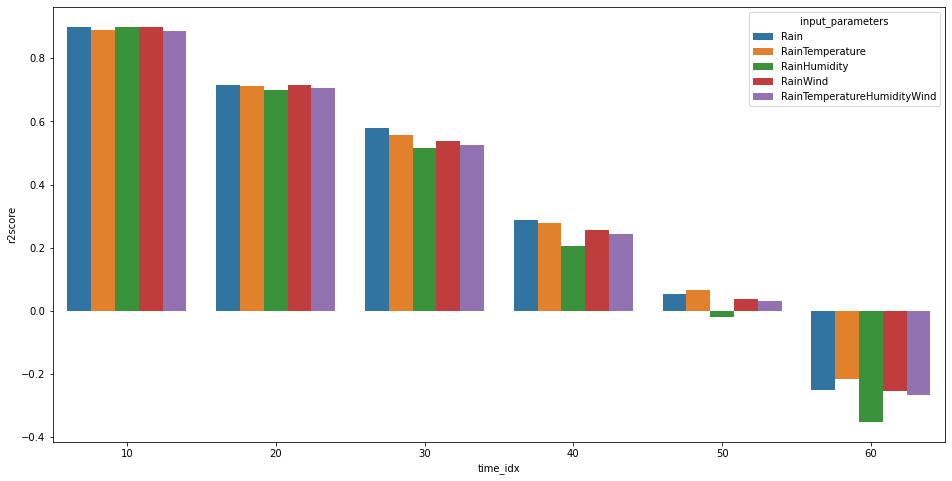

In [37]:
plt.figure(figsize=(16, 8))
sns.barplot(data=all_data_rmse_df, x="time_idx", y="r2score", hue="input_parameters", hue_order=target_cols)
ax = ax.set_xlabel("forcast period (min)")

In [38]:
# grouping by date
def get_grouped_case_date(case_name: str) -> str:
    # TC case
    if "2019-10-04" in case_name:
        return "2019-10-04"
    elif "2020-07-04" in case_name:
        return "2020-07-04"
    elif "2019-10-12" in case_name:
        return "2019-10-12"

    # Not TC case
    elif "2020-09-14" in case_name:
        return "2020-09-14"
    elif "2020-08-07" in case_name:
        return "2020-08-07"
    elif "2020-10-12" in case_name:
        return "2020-10-12"
    else:
        return "else"


each_date_rmse_df = pd.DataFrame(columns=["input_parameters", "date", "rmse", "r2_score", "max_rainfall"])
all_data_metrics_df["date"] = all_data_metrics_df["case_name"].apply(get_grouped_case_date)
for group_name, df in all_data_metrics_df.groupby(by=["input_parameters", "date"]):
    rmse_val = get_rmse_from_df(pred_result_df=df)
    r2score_val = get_r2_score_from_df(pred_result_df=df)
    max_rainfall = df["hour-rain"].max()
    each_date_rmse_df.loc[len(each_date_rmse_df)] = [group_name[0], group_name[1], rmse_val, r2score_val, max_rainfall]

each_case_rmse_df = pd.DataFrame(columns=["input_parameters", "case_name", "date", "rmse", "r2_score", "max_rainfall"])
for group_name, df in all_data_metrics_df.groupby(by=["input_parameters", "case_name"]):
    rmse_val = get_rmse_from_df(pred_result_df=df)
    r2score_val = get_r2_score_from_df(pred_result_df=df)
    max_rainfall = df["hour-rain"].max()
    date = df["date"].to_numpy()[0]
    each_case_rmse_df.loc[len(each_case_rmse_df)] = [group_name[0], group_name[1], date, rmse_val, r2score_val, max_rainfall]

each_date_rmse_df.head()

,input_parameters,date,rmse,r2_score,max_rainfall
0,Rain,2019-10-04,4.666883,0.371093,63.5
1,Rain,2019-10-12,9.533755,0.274798,59.5
2,Rain,2020-07-04,7.622096,0.459230,66.0
3,Rain,2020-08-07,6.577309,0.443414,72.5
4,Rain,2020-09-14,9.248627,0.292550,76.0


In [39]:
each_case_rmse_df.head()

,input_parameters,case_name,date,rmse,r2_score,max_rainfall
0,Rain,NOT_TC_case_2019-10-04_4-0_start,2019-10-04,5.374842,-0.011538,51.5
1,Rain,NOT_TC_case_2019-10-04_4-20_start,2019-10-04,8.901619,-0.026489,63.5
2,Rain,NOT_TC_case_2019-10-04_4-40_start,2019-10-04,6.422574,0.633044,63.5
3,Rain,NOT_TC_case_2019-10-04_5-0_start,2019-10-04,4.972394,0.746043,63.5
4,Rain,NOT_TC_case_2019-10-04_5-20_start,2019-10-04,6.123614,0.302467,61.5


In [40]:
each_date_rmse_df.loc[each_date_rmse_df["input_parameters"].isin(target_cols)].sort_values(by=["input_parameters", "date"], ascending=False)

,input_parameters,date,rmse,r2_score,max_rainfall
83,RainWind,2020-10-12,10.483633,0.328324,82.0
82,RainWind,2020-09-14,9.412539,0.267252,76.0
81,RainWind,2020-08-07,6.882924,0.390489,72.5
80,RainWind,2020-07-04,7.478639,0.479394,66.0
79,RainWind,2019-10-12,9.229252,0.320384,59.5
78,RainWind,2019-10-04,4.899369,0.306872,63.5
59,RainTemperatureHumidityWind,2020-10-12,10.429604,0.335229,82.0
58,RainTemperatureHumidityWind,2020-09-14,9.324338,0.280920,76.0
57,RainTemperatureHumidityWind,2020-08-07,6.802339,0.404678,72.5
56,RainTemperatureHumidityWind,2020-07-04,7.724019,0.444670,66.0


In [41]:
each_case_rmse_df.loc[each_case_rmse_df["date"] == "2020-07-04"].sort_values(by=["r2_score"], ascending=False)

,input_parameters,case_name,date,rmse,r2_score,max_rainfall
604,RainTemperatureHumidityAbs_wind,NOT_TC_case_2020-07-04_7-20_start,2020-07-04,7.564280,0.798744,66.0
532,RainTemperatureHumidity,NOT_TC_case_2020-07-04_7-20_start,2020-07-04,7.798445,0.786091,66.0
388,RainTemperature,NOT_TC_case_2020-07-04_7-20_start,2020-07-04,7.919561,0.779395,66.0
460,RainTemperatureAbs_wind,NOT_TC_case_2020-07-04_7-20_start,2020-07-04,7.993700,0.775246,66.0
892,RainTemperatureWindAbs_wind,NOT_TC_case_2020-07-04_7-20_start,2020-07-04,8.124456,0.767833,66.0
...,...,...,...,...,...,...
527,RainTemperatureHumidity,NOT_TC_case_2020-07-04_10-40_start,2020-07-04,0.377356,-55.964766,0.5
815,RainTemperatureWind,NOT_TC_case_2020-07-04_10-40_start,2020-07-04,0.382400,-57.497740,0.5
239,RainHumidityWind,NOT_TC_case_2020-07-04_10-40_start,2020-07-04,0.386825,-58.859518,0.5
959,RainWind,NOT_TC_case_2020-07-04_10-40_start,2020-07-04,0.390385,-59.966311,0.5


In [42]:
each_case_timeseries_rmse_df = pd.DataFrame(columns=["input_parameters", "case_name", "time_idx", "rmse", "r2_score", "max_rainfall"])
for group_name, df in all_data_metrics_df.groupby(by=["input_parameters", "case_name", "time_idx"]):
    rmse_val = get_rmse_from_df(pred_result_df=df)
    r2score_val = get_r2_score_from_df(pred_result_df=df)
    max_rainfall = df["hour-rain"].max()
    each_case_timeseries_rmse_df.loc[len(each_case_timeseries_rmse_df)] = [group_name[0], group_name[1], group_name[2], rmse_val, r2score_val, max_rainfall]

each_case_timeseries_rmse_df.head()

,input_parameters,case_name,time_idx,rmse,r2_score,max_rainfall
0,Rain,NOT_TC_case_2019-10-04_4-0_start,10,0.631423,-0.788605,2.5
1,Rain,NOT_TC_case_2019-10-04_4-0_start,20,0.696381,-0.510794,3.0
2,Rain,NOT_TC_case_2019-10-04_4-0_start,30,0.970450,-0.037872,3.5
3,Rain,NOT_TC_case_2019-10-04_4-0_start,40,3.807273,-0.019301,19.5
4,Rain,NOT_TC_case_2019-10-04_4-0_start,50,7.208847,-0.045747,36.5


Text(0.5, 0, 'forcast period (min)')

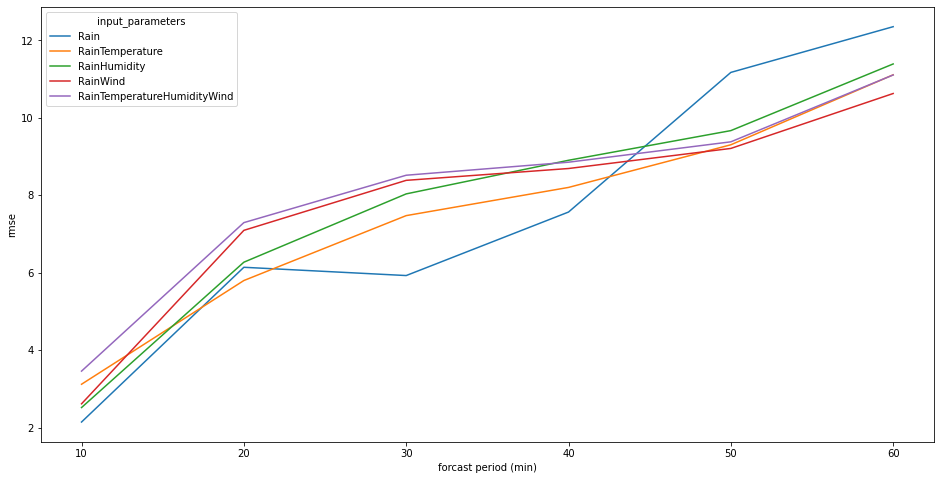

In [43]:
plt.figure(figsize=(16, 8))
data_df = each_case_timeseries_rmse_df.loc[
    (each_case_timeseries_rmse_df["case_name"] == "NOT_TC_case_2020-07-04_7-20_start")
    & (each_case_timeseries_rmse_df["input_parameters"].isin(target_cols))]
ax = sns.lineplot(data=data_df, x="time_idx", y="rmse", hue="input_parameters", hue_order=target_cols)
ax.set_xlabel("forcast period (min)")

Text(0.5, 0, 'forcast period (min)')

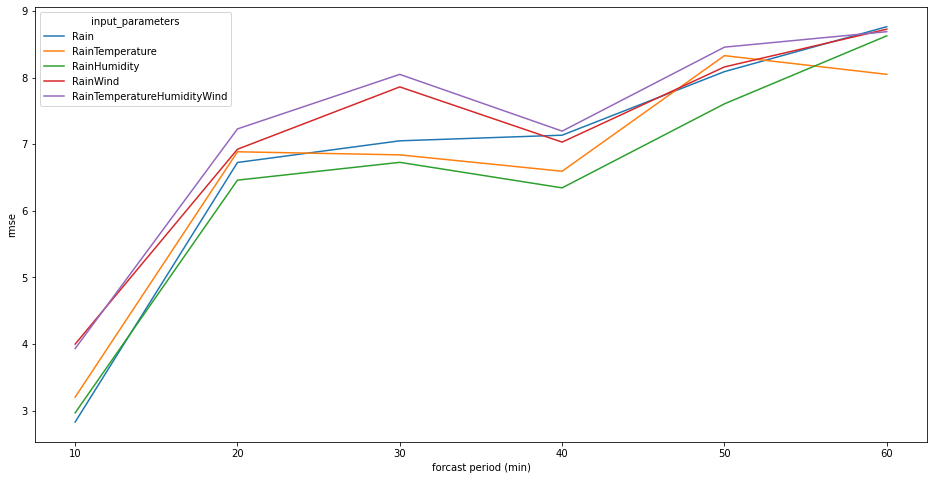

In [44]:
plt.figure(figsize=(16, 8))
data_df = each_case_timeseries_rmse_df.loc[
    (each_case_timeseries_rmse_df["case_name"] == "TC_case_2020-08-07_4-40_start")
    & (each_case_timeseries_rmse_df["input_parameters"].isin(target_cols))]
ax = sns.lineplot(data=data_df, x="time_idx", y="rmse", hue="input_parameters", hue_order=target_cols)
ax.set_xlabel("forcast period (min)")

Text(0.5, 0, 'forcast period (min)')

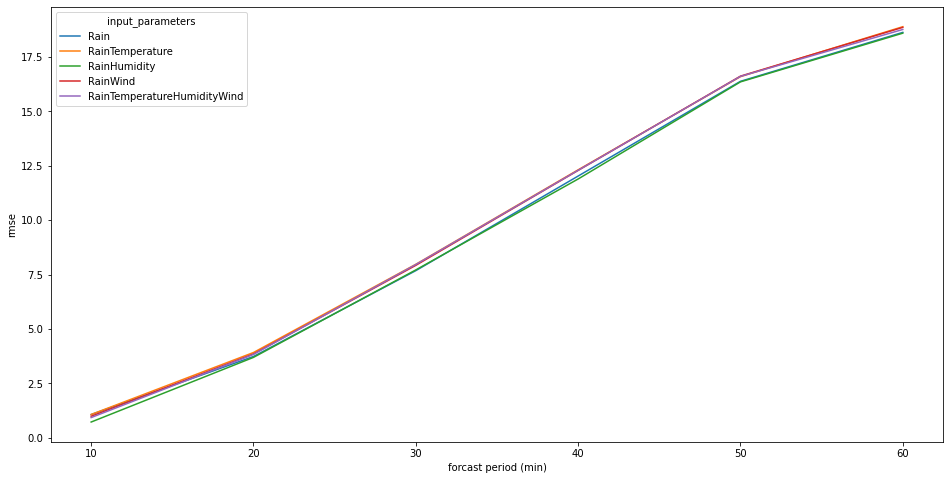

In [45]:
plt.figure(figsize=(16, 8))
data_df = each_case_timeseries_rmse_df.loc[
    (each_case_timeseries_rmse_df["case_name"] == "TC_case_2020-08-07_4-0_start")
    & (each_case_timeseries_rmse_df["input_parameters"].isin(target_cols))]
ax = sns.lineplot(data=data_df, x="time_idx", y="rmse", hue="input_parameters", hue_order=target_cols)
ax.set_xlabel("forcast period (min)")

In [46]:
all_data_metrics_df.head()

,Pred_Value,hour-rain,case_name,input_parameters,time_idx,date
0,0.364,0.0,NOT_TC_case_2019-10-04_5-20_start,RainWind,10,2019-10-04
1,1.812,0.5,NOT_TC_case_2019-10-04_5-20_start,RainWind,10,2019-10-04
2,0.406,0.0,NOT_TC_case_2019-10-04_5-20_start,RainWind,10,2019-10-04
3,7.147,5.5,NOT_TC_case_2019-10-04_5-20_start,RainWind,10,2019-10-04
4,9.47,8.0,NOT_TC_case_2019-10-04_5-20_start,RainWind,10,2019-10-04


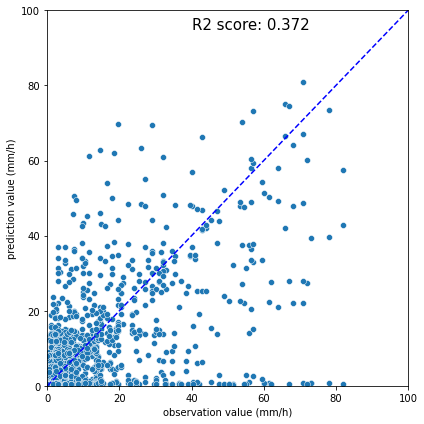

In [65]:
input_parameters = "RainTemperature"
df_loc_query = (all_data_metrics_df["date"] == "2020-10-12") & \
    (all_data_metrics_df["input_parameters"] == input_parameters)
    # (all_data_metrics_df["case_name"].str.endswith("-0_start")) &\

case_data_df = all_data_metrics_df.loc[df_loc_query]

r2 = r2_score(case_data_df["hour-rain"].to_numpy().astype(float), case_data_df["Pred_Value"].to_numpy().astype(float))
r2 = np.round(r2, decimals=3)
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(data=all_data_metrics_df.loc[df_loc_query], x="hour-rain", y="Pred_Value")
ax.text(40, 95, f"R2 score: {r2}", size=15)
r2_plot_x = np.linspace(0, 100, 10)
ax.plot(r2_plot_x, r2_plot_x, color="blue", linestyle="--")
ax.set_ylabel("prediction value (mm/h)")
ax.set_xlabel("observation value (mm/h)")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()

In [53]:
len(all_data_metrics_df.loc[all_data_metrics_df["case_name"] == "NOT_TC_case_2019-10-04_5-20_start"])

2268

In [55]:
2268 / 6

378.0